<a href="https://colab.research.google.com/github/parikshit23/MMML_HW1/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline
tf.__version__


'1.14.0'

In [0]:
# Now let's define the path to our train, validation and test directories
dataset_path = "/content/drive/My Drive/Image_recognition/chest_xray"



# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")



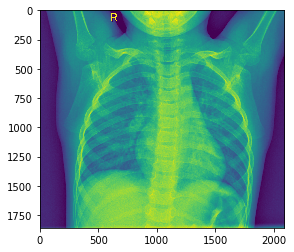

In [4]:
example_img = mpimg.imread(str(train_dir) + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)
#/content/drive/My Drive/Image_recognition/chest_xray/train/NORMAL/IM-0115-0001.jpeg

In [0]:
# Plotting samples of few images of pneumonia and Normal cases side by side for comparison 

In [0]:
'''
Mandatory:
dataset: string, dataset from where we extract images
category: string, category within the dataset (NORMAL, PNEUMONIA)

Optional:
labeled: boolean, determine if images should be labeled
sample_size: int, number of images to display
'''
def plot_img(subset, category, labeled = False, sample_size = 6):
  
  full_path = dataset_path + subset + '/' + category
  
  # Check if sample_size is valid
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
    
  # Define the figure size
  plt.figure(figsize=(18, 12))
  
  for i, file in enumerate(os.listdir(full_path)):

    # Check if number of images to display has been reached
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(231 + i)

    if labeled:
      plt.title(file.split('-')[1])
    
    plt.imshow(img)


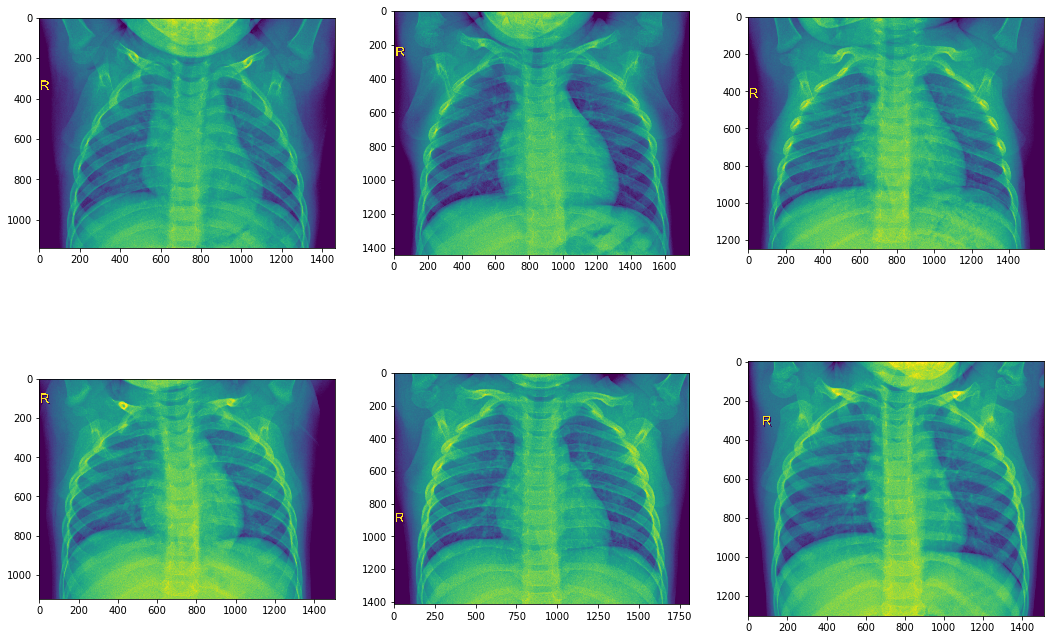

In [7]:
# Calling the above function
plot_img("/train", "NORMAL")



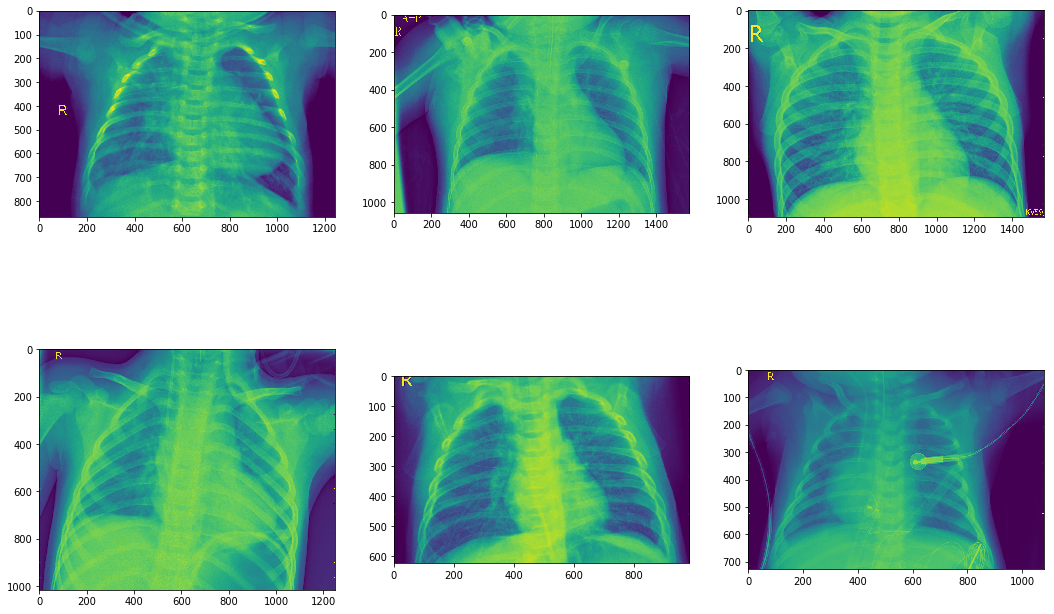

In [8]:
# With pneumonia cases
plot_img("/train", "PNEUMONIA")

### Now let's make a function to compare an image shwocasing pneumonia with another one which is normal


In [0]:
def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()


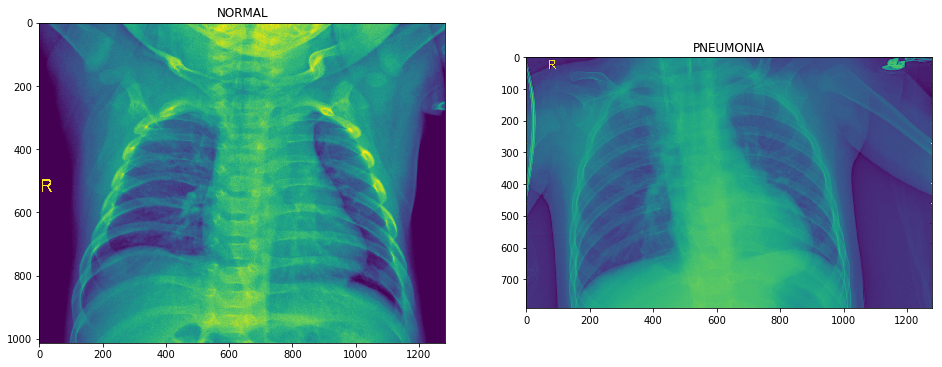

In [11]:
# Let's compare one image showasing pneumonia and one normal
compare_img("/train", labeled = True)

## Building the model
### Loading the pre-trained model (InceptionV3)

In [0]:
IMG_SHAPE = (150, 150, 3)

In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 3s 0us/step


### Base architecture of the inceptionV3 model

In [14]:
base_model.summary() # This is quite a complex architecture

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Freezing the base model

In [0]:
base_model.trainable = False

### Defining the custom head for our network

In [16]:
base_model.output

<tf.Tensor 'mixed10/concat:0' shape=(?, 3, 3, 2048) dtype=float32>

In [0]:
#Using a pooling layer to reduce the output dimension
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)


In [18]:
global_average_layer

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(?, 2048) dtype=float32>

In [0]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

### Defining the model

In [0]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Compiling the model


In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

### Creating Data Generators 

In [0]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [24]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [25]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [26]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


### Training the model

In [27]:
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 1476s 36s/step - loss: 0.4996 - acc: 0.7855 - val_loss: 0.7583 - val_acc: 0.6875
Epoch 2/5
41/41 [==============================] - 324s 8s/step - loss: 0.3170 - acc: 0.8723 - val_loss: 0.9749 - val_acc: 0.7500
Epoch 3/5
41/41 [==============================] - 329s 8s/step - loss: 0.2581 - acc: 0.8967 - val_loss: 1.4780 - val_acc: 0.6250
Epoch 4/5
41/41 [==============================] - 329s 8s/step - loss: 0.2354 - acc: 0.9047 - val_loss: 1.0310 - val_acc: 0.6875
Epoch 5/5
41/41 [==============================] - 331s 8s/step - loss: 0.2165 - acc: 0.9122 - val_loss: 1.1597 - val_acc: 0.7500


### Transfer learning model evaluation

In [0]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [29]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.75


### Plotting the results


In [0]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)


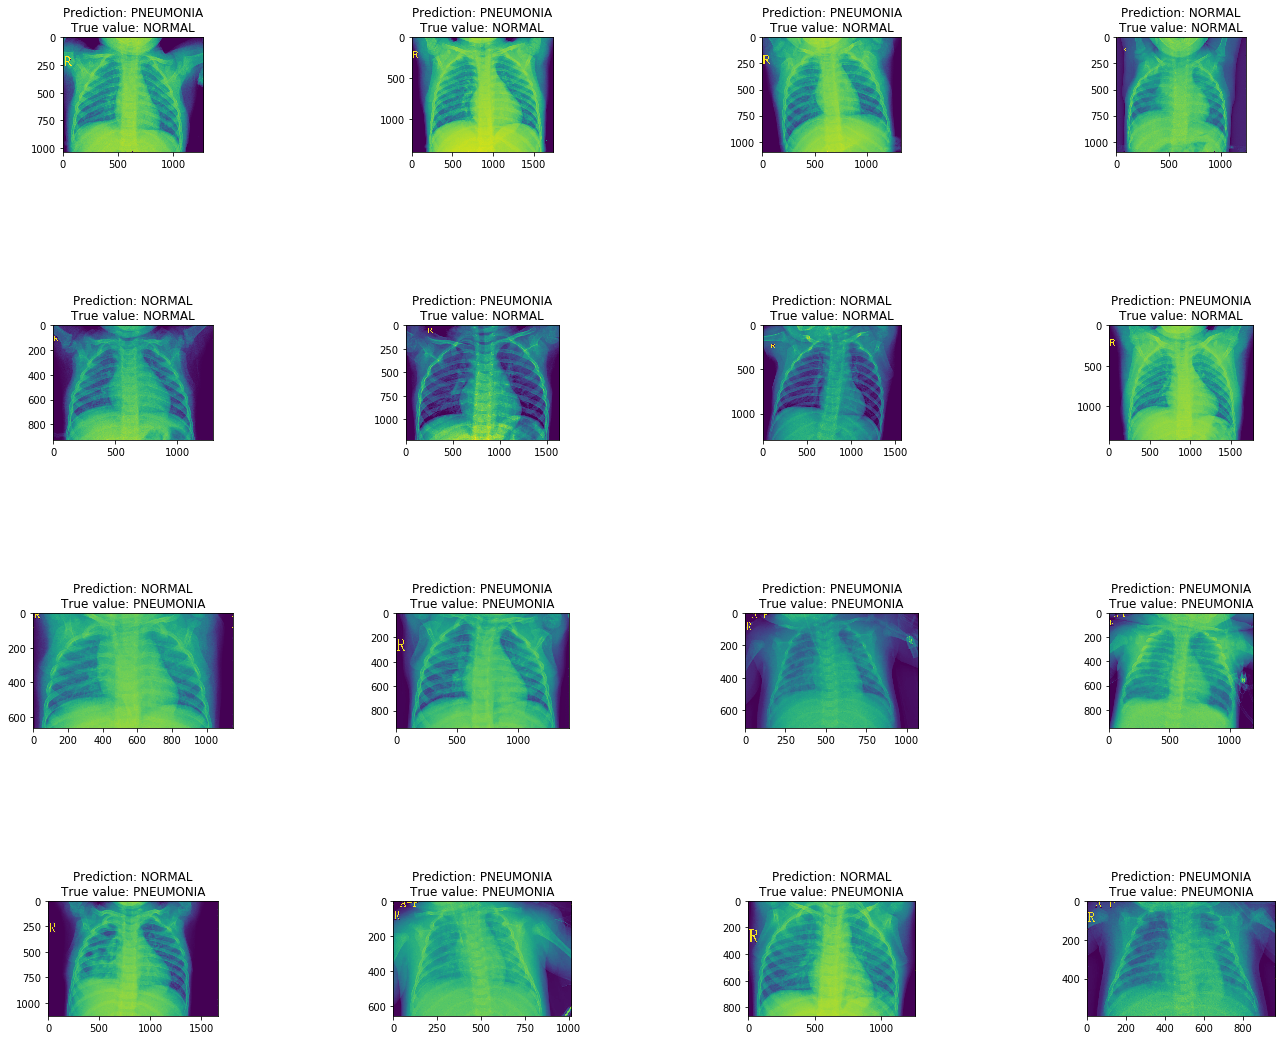

In [31]:
compare_results(validation_dir, valid_generator)

### Saving the model


In [32]:
import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
#Fine tuning

### Un-freeze a few top layers from the model


In [0]:
base_model.trainable = True

In [34]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 311


In [0]:
# Defining the unfreezing starting point
fine_tune_at = 200

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

### Compiling the model for fine tuning

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fine tuning

In [38]:
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
41/41 [==============================] - 601s 15s/step - loss: 0.1411 - acc: 0.9486 - val_loss: 3.3783 - val_acc: 0.6250
Epoch 2/5
41/41 [==============================] - 588s 14s/step - loss: 0.0326 - acc: 0.9900 - val_loss: 4.1258 - val_acc: 0.6250
Epoch 3/5
41/41 [==============================] - 593s 14s/step - loss: 0.0120 - acc: 0.9958 - val_loss: 3.4397 - val_acc: 0.6875
Epoch 4/5
41/41 [==============================] - 590s 14s/step - loss: 0.0068 - acc: 0.9981 - val_loss: 2.9512 - val_acc: 0.7500
Epoch 5/5
41/41 [==============================] - 588s 14s/step - loss: 0.0085 - acc: 0.9973 - val_loss: 4.4535 - val_acc: 0.5625


### Evaluating the fine tuning

In [0]:


valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)



In [42]:
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))

Validation accuracy after fine tuning: 0.5625


### Plotting the new results

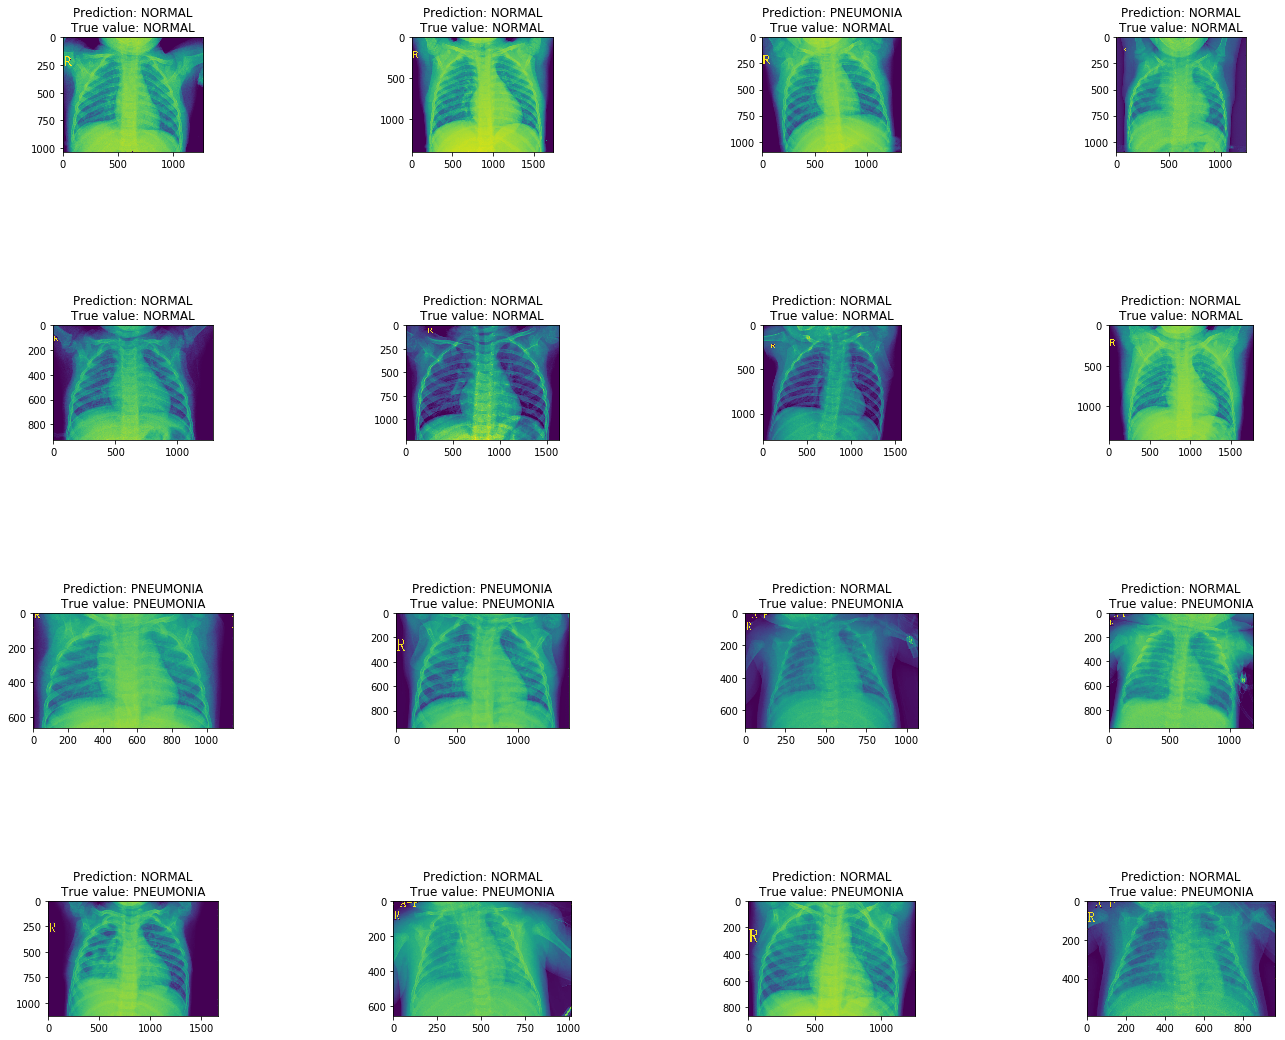

In [41]:
compare_results(validation_dir, valid_generator)